In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import joblib
import os

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

random = 42

In [20]:
data = pd.read_csv('./data250824.csv', index_col=[0], header=[0])

In [21]:
y = data['pIC50']
#X = data[[# Save PC scores to CSV

X = data[['X2', 'X4', 'X15', 'X16']]
X_train = X[:22]
X_test = X[22:28]
X_val = X[28:37]

structures = data.index.tolist()

In [22]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# PCA
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)
X_val_pca_full = pca.transform(X_val_scaled)


In [23]:
# Step 3: Keep only first 2 principal components
X_train_pca = X_train_pca_full[:, :2]
X_test_pca = X_test_pca_full[:, :2]
X_val_pca = X_val_pca_full[:, :2]


In [24]:
import pandas as pd

df_train = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_test = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
df_val = pd.DataFrame(X_val_pca, columns=['PC1', 'PC2'])

df_train['Group'] = 'train'
df_test['Group'] = 'test'
df_val['Group'] = 'val'

pca_df = pd.concat([df_train, df_test, df_val], ignore_index=True)

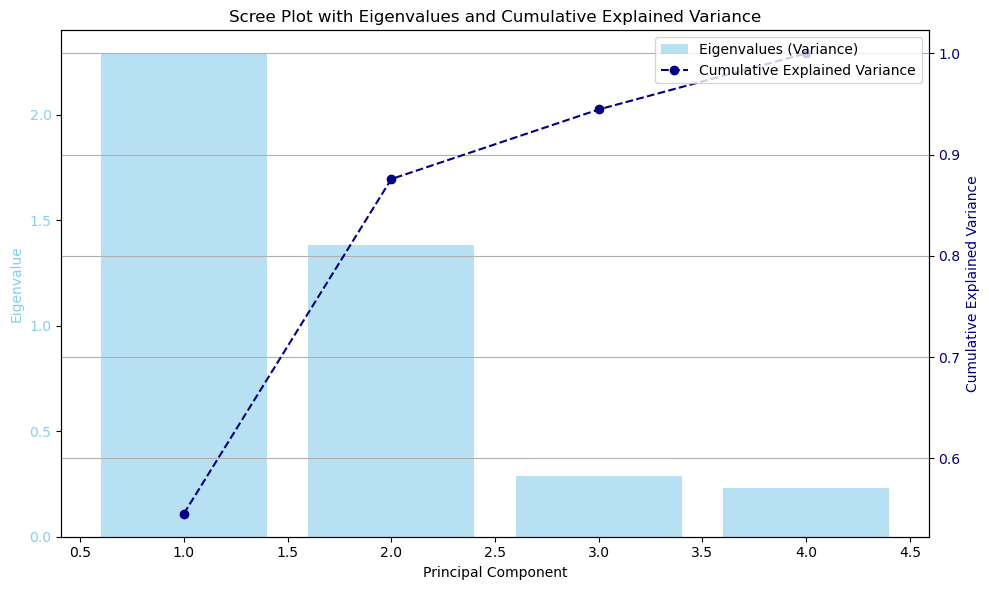

In [16]:
# Get eigenvalues and explained variance
eigenvalues = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)

# Set up figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for eigenvalues
ax1.bar(
    range(1, len(eigenvalues) + 1),
    eigenvalues,
    alpha=0.6,
    label='Eigenvalues (Variance)',
    color='skyblue'
)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line plot for cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    marker='o',
    linestyle='--',
    color='navy',
    label='Cumulative Explained Variance'
)
ax2.set_ylabel('Cumulative Explained Variance', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

# Title and legend
plt.title('Scree Plot with Eigenvalues and Cumulative Explained Variance')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()

In [25]:
# Save PC scores to CSV
pca_df.to_csv('pca_scores.csv', index=False)

# Eigenvectors dataframe (components x features)
eigenvectors_df = pd.DataFrame(pca.components_)
eigenvectors_df.to_csv('pca_eigenvectors.csv', index=False)

# Explained variance ratio dataframe
pcs = [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
explained_variance_df = pd.DataFrame({
    'PC': pcs,
    'Explained Variance Ratio': pca.explained_variance_ratio_
})
explained_variance_df.to_csv('pca_explained_variance.csv', index=False)

print("Saved PCA results to CSV files:")
print("- pca_scores.csv (PC1 and PC2 values)")
print("- pca_eigenvectors.csv (eigenvectors / loadings)")
print("- pca_explained_variance.csv (variance ratios)")

Saved PCA results to CSV files:
- pca_scores.csv (PC1 and PC2 values)
- pca_eigenvectors.csv (eigenvectors / loadings)
- pca_explained_variance.csv (variance ratios)


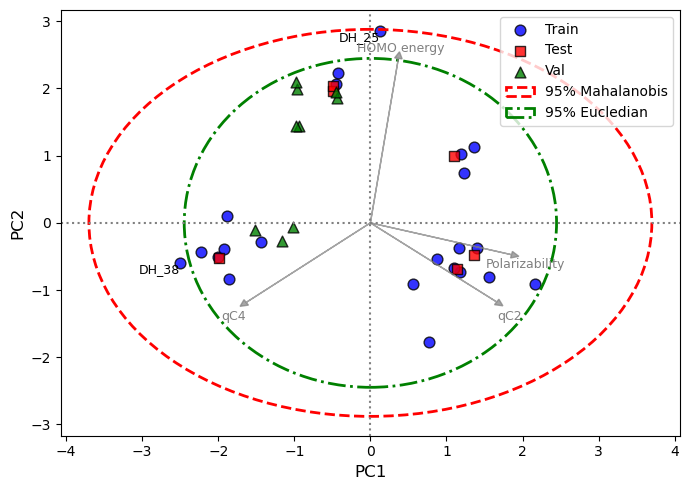

In [26]:
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis, euclidean
from scipy.stats import chi2
from scipy.linalg import eigh
from matplotlib.patches import Ellipse, Circle

# --- 2. Covariance Estimation (Ledoit-Wolf) ---
lw = LedoitWolf().fit(X_train_pca)
#mean_vec = lw.location_              # This is the mean vector
cov_matrix = np.cov(X_train_pca, rowvar=False)
epsilon = 1e-6
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon
inv_cov = np.linalg.inv(cov_matrix)
mean_vec = np.mean(X_train_pca, axis=0)

# --- 3. Mahalanobis Distances ---
md_train = np.array([mahalanobis(x, mean_vec, inv_cov) for x in X_train_pca])
md_test  = np.array([mahalanobis(x, mean_vec, inv_cov) for x in X_test_pca])
md_val   = np.array([mahalanobis(x, mean_vec, inv_cov) for x in X_val_pca])

# --- Euclidean Distances ---
ed_train = np.array([euclidean(x, mean_vec) for x in X_train_pca])
ed_test  = np.array([euclidean(x, mean_vec) for x in X_test_pca])
ed_val   = np.array([euclidean(x, mean_vec) for x in X_val_pca])

# Empirical 95% threshold on training distances
#threshold_md = np.percentile(md_train, 95)
threshold = chi2.ppf(0.95, df=2)

# --- 4. Combine for plotting ---
combined = np.vstack([X_train_pca, X_test_pca, X_val_pca])
groups   = (['Train']*len(md_train) +
            ['Test'] *len(md_test)  +
            ['Val']  *len(md_val))
md_all   = np.concatenate([md_train, md_test, md_val])
ed_all   = np.concatenate([ed_train, ed_test, ed_val])

# Build DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(combined, columns=['PC1','PC2'], index=data[:37].index)
df['Group'] = groups
df['MD']    = md_all
df['Outlier-MD'] = df['MD']**2 > threshold
df['ED']    = ed_all
df['Outlier-ED'] = df['ED']**2 > threshold

# --- 4. Ellipse plotting function ---
def plot_mahalanobis_ellipse(mean, cov, threshold, ax, **kwargs):
    vals, vecs = eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    width, height = 2 * np.sqrt(vals * threshold)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

def plot_euclidean_circle(mean, threshold, ax, **kwargs):
    """
    Plots a confidence circle (Euclidean distance) in 2D.
    
    Parameters:
    - mean: (x, y) center of the circle
    - confidence_level: float (e.g., 0.95)
    - ax: matplotlib Axes
    - kwargs: styling options (e.g., edgecolor, linewidth)
    """
    # Chi-square threshold for 2 DOF
    radius = np.sqrt(threshold)

    # Draw the circle
    circle = Circle(xy=mean, radius=radius, **kwargs)
    ax.add_patch(circle)

# --- 5. Plot ---
# Define manual mappings
group_styles = {
    'Train': {'color': 'blue', 'marker': 'o'},
    'Test':  {'color': 'red',  'marker': 's'},
    'Val':   {'color': 'green','marker': '^'}
}

# --- Plot ---
fig, ax = plt.subplots(figsize=(7,5))

# Plot each group with its specific color and marker
for group, style in group_styles.items():
    group_data = df[df['Group'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               label=group,
               color=style['color'],
               marker=style['marker'],
               alpha=0.8, edgecolor='black', s=60)

# Label the outliers with their index
outliers = df[df['Outlier-MD'] | df['Outlier-ED']]
for idx, row in outliers.iterrows():
    ax.text(row['PC1'], row['PC2'], str(idx), color='black', fontsize=9, ha='right', va='top')

plot_mahalanobis_ellipse(mean=mean_vec, cov=cov_matrix, threshold=threshold, ax=ax,
                         edgecolor='red', facecolor='none', linewidth=2, ls='--', label='95% Mahalanobis')
plot_euclidean_circle(mean=mean_vec, threshold=threshold, ax=ax,
                      edgecolor='green', facecolor='none', linewidth=2, ls='-.', label='95% Eucledian')

# --- Add PCA loading vectors (PC1 and PC2 directions) ---
feature_names = X.columns

label_mapping = {'X2':'qC2', 'X4':'qC4', 'X15':'Polarizability', 'X16':'HOMO energy'}

loadings = pca.components_[:2].T  # shape: (n_features, 2)
scaling_factor = 3  # adjust as needed

for i, (x, y) in enumerate(loadings):
    ax.arrow(0, 0, x * scaling_factor, y * scaling_factor, 
             color='gray', alpha=0.7, head_width=0.1, head_length=0.1)
    
    # Use label mapping if available, else fallback to original name
    label = label_mapping.get(feature_names[i], feature_names[i])
    ax.text(x * scaling_factor * 1.1, y * scaling_factor * 1.1, 
            label, color='gray', ha='center', va='top', fontsize=9)

# Styling
plt.axhline(0, color='gray', ls=':')
plt.axvline(0, color='gray', ls=':')
plt.xlabel('PC1', fontsize=12); plt.ylabel('PC2',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig("pc-mahal-euclid.tif", dpi=330)
plt.show()

In [10]:
print(df)

NameError: name 'df' is not defined